<html style="background-color: white">
    <head style="background-color: white">
        <div style="position: relative; width: 1084px; margin: 50px auto; padding: 15px auto;">
            <figure style="max-width: 500px; float:left; padding: 10px; margin: 10px;">
                <a href="https://decide4ai.com/" target="_blank"><img style="padding: px; margin: 0;" src="./recursos/imagenes/FULLCOLOR.png" alt="logo decide"></a>
            </figure>
            <figure style="max-width: 500px; float:left; padding: 10px; margin: 32px 10px 10px 10px;">
                <a href="https://t3chfest.es/2023/" target="_blank"><img style="padding: 0; margin: 0;" src="./recursos/imagenes/t3f_logo.png" alt="logo t3ch festival"></a>
            </figure>
        </div>
        <div style="position: relative; border-top:3px solid #002060; border-bottom:3px solid #002060; margin-top: 300px; height: 140px; margin-right: auto; margin-left: auto;">
            <a href="./u3c3.ipynb" target="_blank"><img style="float: left; height: 64px; width: 76px;  margin:2% 1% 1% 7%;" src="./recursos/imagenes/ICON-FULLCOLOR-ROT.png" alt="icono decide4ai rotado"></a>
            <h1 style="color: #002060; text-align: center; margin: 1% 0; padding: 0; width: 70%; float: left;">
                Unidad 4: Introducción a RSs basados en Reinforcement Learning - Multi-Armed Bandit problem<br><a href="./indice.ipynb" style="font-size: 10px; color: #bf27b8">Volver al índice</a>
            </h1>
            <a href="./referencias.ipynb" target="_blank"><img style="float: left; height: 64px; width: 76px; margin:2% auto 1% 1%;" src="./recursos/imagenes/ICON-FULLCOLOR.png" alt="icono decide4ai"></a>
        </div>
    </head>
</html>

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import random
import math 

from IPython.display import Image

En esta unidad extra presentamos los sistemas de recomendación desde un punto de vista diferente: el del aprendizaje por refuerzo o **reinforcement learning**. En particular vamos a ver una introducción a una familia de algoritmos denominados Multi-Armed Bandits que, en la actualidad, se utilizan en sistemas de recomendación relacionados sobre todo con temas de marketing digital.

## Multi-Armed Bandit problem

El Multi-Armed Bandit problem es un problema clásico del aprendizaje por refuerzo. Se plantea como un experimento hipotético en el que un jugador recibe una máquina tragaperras con varios brazos y sabe que unos le van a dar más recompensa que otros, pero no sabe cuáles. Su objetivo es ir tirando de los brazos para obtener la mayor recompensa posible al terminar de jugar. La pregunta que le surge es: ¿Cuál es la mejor estrategia que tengo que seguir para conseguir el mayor beneficio a largo plazo? 

Si entendemos los brazos por contenidos de streaming o por noticias que ofrecer, el objetivo sería aprender iterativamente para ofrecer al usuario aquello que reporte más beneficio. 

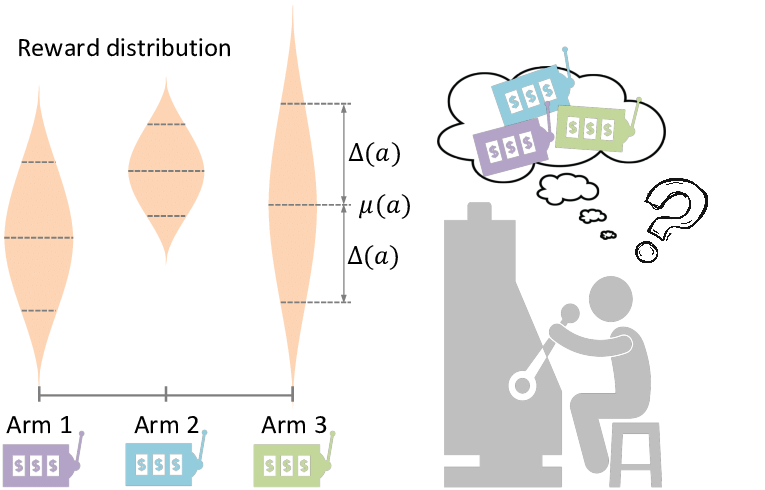

In [46]:
Image(filename=r'recursos\imagenes\reward_distribution.png')


¿Se debería explotar su conocimiento actual para maximizar la recompensa inmediata o debería explorar nuevas opciones para obtener información valiosa que pueda mejorar su rendimiento a largo plazo?

Esta situación se conoce como el **dilema de exploración / explotación**, que se da frecuentemente en el ámbito del aprendizaje por refuerzo, pero también en nuestra vida diaria. ¿Vamos a cenar a un restaurante nuevo a riesgo de que no nos guste o volvemos a ir a aquel que ya sabemos que va a estar bien?

Una de las claves de los algoritmos de Multi-Armed Bandits es que equilibran esta exploración y explotación: probar recomendaciones nuevas (explorar) y mostrar las recomendaciones con mayor probabilidad de éxito (explotar).


_____________

## Ejemplo de implementación: Optimización de Click-Through Rate

In [3]:
# Cargamos el dataset
path = './recursos/datos/'
dataset = pd.read_csv(path + 'Ads_CTR_Optimisation.csv')

En este ejemplo vemos una situación diferente al del casino. En lugar de brazos máquinas tragaperras vamos a tener anuncios. En este caso, queremos ir aprendiendo qué anuncio generó la mayor cantidad de recompensas (clicks) interaccionando con los usuarios. 

El dataset contiene una columna por cada anuncio (ad), con un total de 10 anuncios y 10 000 rondas (o iteraciones). Cada ronda es una fila que indica si se hizo click en el anuncio (1) o no (0). El anuncio con más clicks después del número total de rondas sería el que consigue mayor *engagement* (CTR).


In [49]:
dataset.head()

Ad 1  Ad 2  Ad 3  Ad 4  Ad 5  Ad 6  Ad 7  Ad 8  Ad 9  Ad 10
0     1     0     0     0     1     0     0     0     1      0
1     0     0     0     0     0     0     0     0     1      0
2     0     0     0     0     0     0     0     0     0      0
3     0     1     0     0     0     0     0     1     0      0
4     0     0     0     0     0     0     0     0     0      0

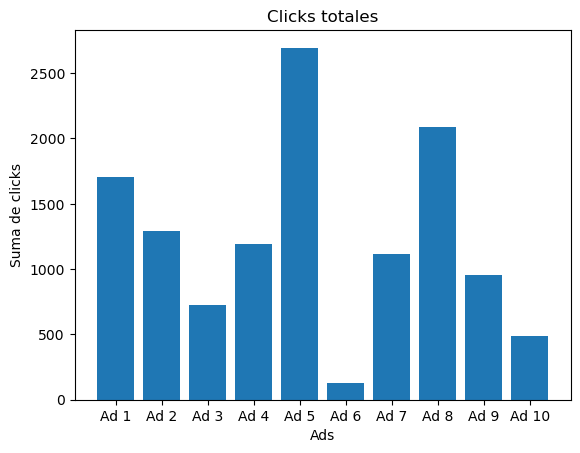

In [67]:
# Sumar cada columna individualmente
column_totals = dataset.sum(axis=0)
column_totals = pd.DataFrame(column_totals).T

plt.bar(column_totals.columns, column_totals.iloc[0, :])
plt.xlabel("Ads")
plt.ylabel("Suma de clicks")
plt.title("Clicks totales")
plt.show()

Pasadas las 10000 iteraciones es fácil ver que el Anuncio 5 es el que mejor funcionó (es el que consigió más clicks), pero esto no nos sirve: **lo estamos viendo a toro pasado.** 

Si tenemos una campaña publicitaria que sólo dura un mes, recogemos estos datos durante ese mes y le decimos después a nuestro cliente que ponga el anuncio 5 mucho que es el que funciona bien, nos dirá que esa información ya no le sirve porque su campaña ya terminó.

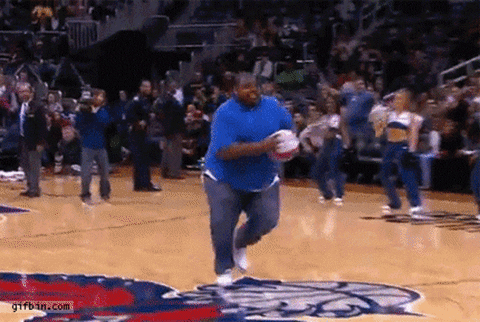

In [68]:
Image(filename=r'recursos\imagenes\gif_fail.gif')

La gracia de hacer un algoritmo de MAB en este tipo de situaciones es conseguir un sistema de recomendación que vaya aprendiendo **ronda a ronda**, iterativamente, para poder adaptarse a lo que mejor funciona **en tiempo real**.

A continuación vemos tres tipos de estrategias o algoritmos sencillos para implementar un MAB usando este dataset como ejemplo. En la literatura se pueden encontrar muchos otros, más complejos, que incluyen información contextual sobre el usuario para añadirle capas de personalización o técnicas de Deep Learning, pero eso queda fuera de los objetivos de esta introducción.

### - Algoritmo $\epsilon$-greedy

Para cada iteración t se toma una acción al azar random con probabilidad $\epsilon$ o se elige la acción de mayor recompensa observada hasta el momento con probabilidad $1-\epsilon$
- $\epsilon$ más alto -> más exploración
- $\epsilon$ más bajo -> más explotación

**¿Cómo se escoge $\epsilon$?**

Una opción es establecer un valor constante (0.01, 0.05, 0.1, ...), que implica que incluso después de haber explorado todas las opciones posibles un número considerable de veces y, por tanto, tener una buena idea de las recompensas que se esperan de cada una, todavía habrá margen para el azar.

Otra opción es hacer que $\epsilon$ dependa del número de iteraciones que se han ido realizando hasta el momento. La idea es que a medida que se recopila más informacion se quiere reducir la exploración, ya que ya sabemos qué recompensas esperar de cada brazo.

In [31]:
# Implementación del algoritmo epsilon-greedy
import random

N = 10000
d = 10
ads_selected_egreedy = []
numbers_of_selections_egreedy = [0] * d
observed_reward_egreedy = []
sum_of_rewards_egreedy = [0] * d
total_reward_egreedy = 0
epsilon = 0.1

for n in range(0, N):
    ad = 0
    max_upper_bound = 0
    if random.random() > epsilon:
        for i in range(0, d):
            if numbers_of_selections_egreedy[i] > 0:
                average_reward = sum_of_rewards_egreedy[i] / numbers_of_selections_egreedy[i]
                if average_reward > max_upper_bound:
                    max_upper_bound = average_reward
                    ad = i               
    else:
        ad = random.randrange(d)
        
    ads_selected_egreedy.append(ad)
    numbers_of_selections_egreedy[ad] = numbers_of_selections_egreedy[ad] + 1
    reward = dataset.values[n, ad]
    observed_reward_egreedy.append(reward)
    sum_of_rewards_egreedy[ad] = sum_of_rewards_egreedy[ad] + reward
    total_reward_egreedy = total_reward_egreedy + reward

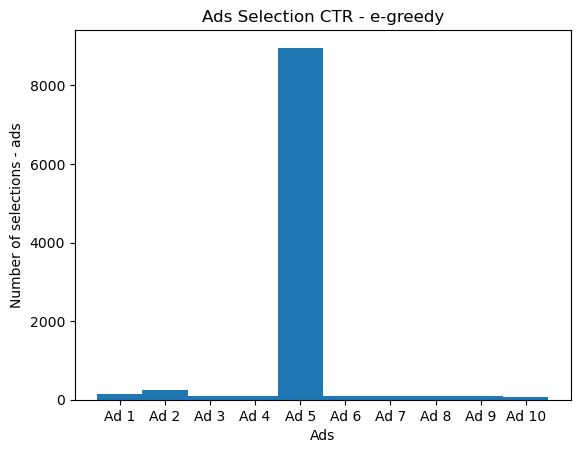

In [40]:
# Visualización de resultados

column_names = ['Ad 1', 'Ad 2', 'Ad 3', 'Ad 4', 'Ad 5', 'Ad 6', 'Ad 7', 'Ad 8', 'Ad 9', 'Ad 10']

_, bins, _ = plt.hist(ads_selected_egreedy)
bar_centers = 0.5 * (bins[:-1] + bins[1:])

plt.title('Ads Selection CTR - e-greedy')
plt.xlabel('Ads')
plt.ylabel('Number of selections - ads')
plt.xticks(bar_centers, column_names)
plt.show()

### - Algoritmo UCB

En el algoritmo anterior sólo se tenía en cuenta cuál era el brazo con mayor recompensa observada, pero no se tenía en cuenta la incertidumbre, es decir, cuánto se sabe sobre el brazo en cuestión. Este algoritmo escoge el brazo teniendo en cuenta por una parte la recompensa esperada y por otra el extremo superior del intervalo de confianza de cada brazo.

A medida que el algoritmo sabe más de cierto brazo, el IC disminuye, con lo que es menos probable que se escoja un cierto brazo si sabe que no da buen rendimiento.

In [33]:
# Implementación del algoritmo UCB

N = 10000
d = 10
ads_selected_ucb = []
numbers_of_selections_ucb = [0]*d 
sum_of_rewards_ucb = [0]*d
total_reward_ucb = 0
observed_reward_ucb = []

for n in range(0, N):
    ad = 0
    max_ub = 0
    for i in range(0, d):
        if (numbers_of_selections_ucb[i] > 0):
            average_reward = sum_of_rewards_ucb[i] / numbers_of_selections_ucb[i]
            del_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections_ucb[i])
            upper_bound = average_reward + del_i
        else:
            upper_bound = 1e400  #establecemos el límite superior en un valor muy grande para asegurarnos de que se seleccione cada ad
        if upper_bound > max_ub:
            max_ub = upper_bound
            ad = i
    ads_selected_ucb.append(ad)
    numbers_of_selections_ucb[ad] = numbers_of_selections_ucb[ad] + 1
    reward = dataset.values[n, ad]
    observed_reward_ucb.append(reward)
    sum_of_rewards_ucb[ad] = sum_of_rewards_ucb[ad] + reward
    total_reward_ucb = total_reward_ucb + reward

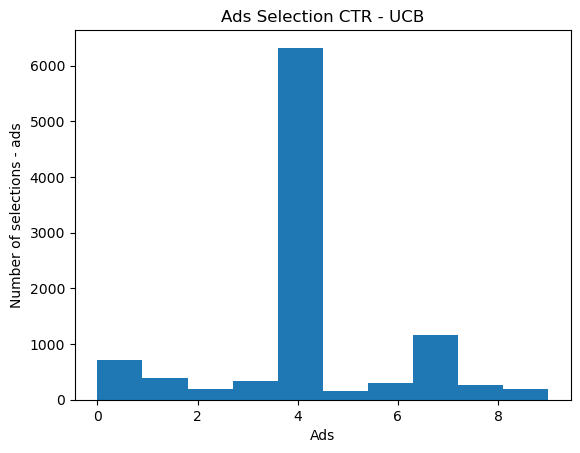

In [34]:
# Visualización de resultados

column_names = ['Ad 1', 'Ad 2', 'Ad 3', 'Ad 4', 'Ad 5', 'Ad 6', 'Ad 7', 'Ad 8', 'Ad 9', 'Ad 10']
_, bins, _ = plt.hist(ads_selected_ucb)
bar_centers = 0.5 * (bins[:-1] + bins[1:])

plt.title('Ads Selection CTR - UCB')
plt.xlabel('Ads')
plt.ylabel('Number of selections - ads')
plt.xticks(bar_centers, column_names)
plt.show()

### - Algoritmo Thompson Sampling

Los dos anteriores algoritmos se basan en el promedio de las recompensas recibidas por cada brazo. El Thompson Sampling toma un enfoque diferente utilizando estadística **bayesiana**; las probabilidades de cada brazo de producir una recompensa se modelan mediante una distribución de probabilidad.

Si se quiere ampliar la información, en este artículo hay una explicación detallada de cómo funciona este algoritmo y por qué se escoge una distribución beta para el caso del reward binario: https://towardsdatascience.com/thompson-sampling-fc28817eacb8

In [36]:
# Implementación del algoritmo Thompson Sampling

N = 10000
d = 10
ads_selected_ts = []
numbers_of_rewards_1 = [0] * d
numbers_of_rewards_0 = [0] * d
total_reward_ts = 0
observed_reward_ts = []

for n in range(0, N):
    ad = 0
    max_random = 0
    for i in range(0, d):
        random_beta = random.betavariate(numbers_of_rewards_1[i] + 1, numbers_of_rewards_0[i] + 1)
        if random_beta > max_random:
            max_random = random_beta
            ad = i
    ads_selected_ts.append(ad)
    reward = dataset.values[n, ad]
    observed_reward_ts.append(reward)
    if reward == 1:
        numbers_of_rewards_1[ad] = numbers_of_rewards_1[ad] + 1
    else:
        numbers_of_rewards_0[ad] = numbers_of_rewards_0[ad] + 1
    total_reward_ts = total_reward_ts + reward

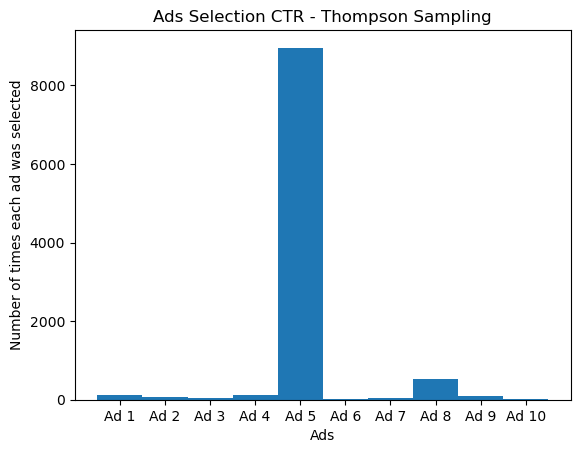

In [41]:
# Visualización de resultados

column_names = ['Ad 1', 'Ad 2', 'Ad 3', 'Ad 4', 'Ad 5', 'Ad 6', 'Ad 7', 'Ad 8', 'Ad 9', 'Ad 10']
_, bins, _ = plt.hist(ads_selected_ts)
bar_centers = 0.5 * (bins[:-1] + bins[1:])

plt.title('Ads Selection CTR - Thompson Sampling')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.xticks(bar_centers, column_names)
plt.show()

In [3]:
7 + 30 + 20 + 50

107

In [2]:
107/60

1.7833333333333334

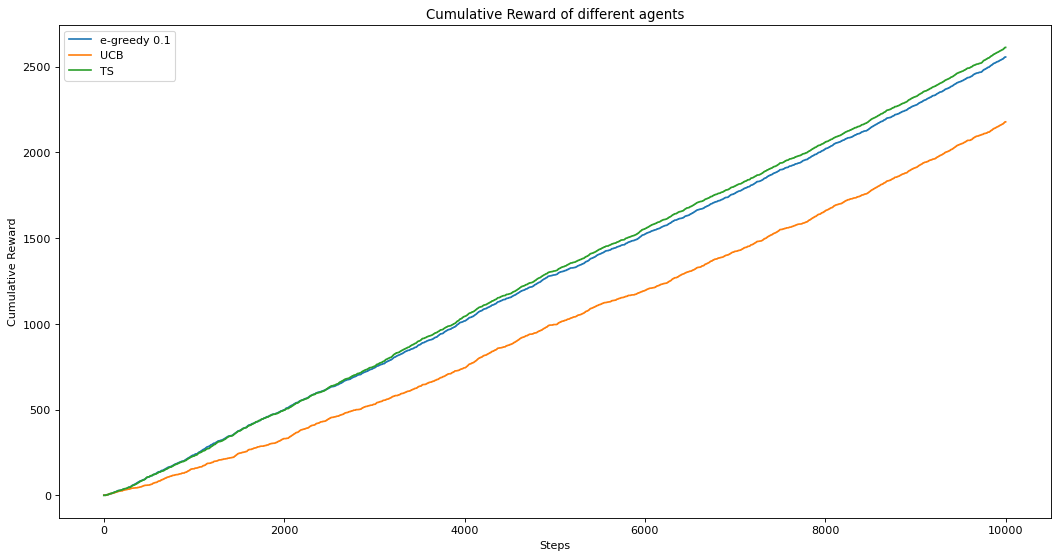

In [45]:
#Comparación del reward acumulado

plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.cumsum(observed_reward_egreedy))
plt.plot(np.cumsum(observed_reward_ucb))
plt.plot(np.cumsum(observed_reward_ts))

plt.legend(["e-greedy " + str(epsilon), "UCB", "TS"])
plt.title("Cumulative Reward of different agents")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward")
plt.show()